<a href="https://colab.research.google.com/github/costpetrides/Brain-Tumor-Classification/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/DATA/BrainTumor/Training'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
train_df = '/content/drive/MyDrive/DATA/BrainTumor/Training/' #training data
test_df = '/content/drive/MyDrive/DATA/BrainTumor/Testing/' #testing data

In [11]:
training_labels = [] #a list for training labels

for label in os.listdir(train_df):
    for image in os.listdir(train_df + label):
        training_labels.append(label)

In [12]:
testing_labels = [] #a list for testing labels

for label in os.listdir(test_df):
    for image in os.listdir(test_df + label):
        testing_labels.append(label)

In [13]:
training_labels_series = pd.Series(training_labels) #converting the list into a serires so I can use value_counts() method
training_labels_series.value_counts()

notumor       1605
pituitary     1457
meningioma    1339
glioma        1321
dtype: int64

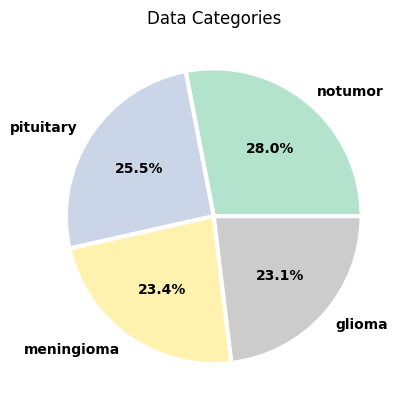

In [26]:
training_labels_series.value_counts().plot.pie(autopct='%.1f%%', cmap = 'Pastel2', textprops={'weight':'bold'}, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }).set_title("Data Categories")
plt.show()

In [27]:
def show_images(rows, columns, data):
    plt.figure(figsize=(columns*2.25, rows*2.25))
    for images, labels in data.take(1):
        for i in range(rows * columns):
            ax = plt.subplot(rows, columns, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off') # Turn off axis labels and ticks
            plt.title(data.class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

In [28]:
batch_size = 32
image_size = (180, 180)

In [30]:
training_data = tf.keras.utils.image_dataset_from_directory(train_df, validation_split=0.2,subset="training",seed=123, image_size = image_size,batch_size=batch_size)

Found 5722 files belonging to 4 classes.
Using 4578 files for training.


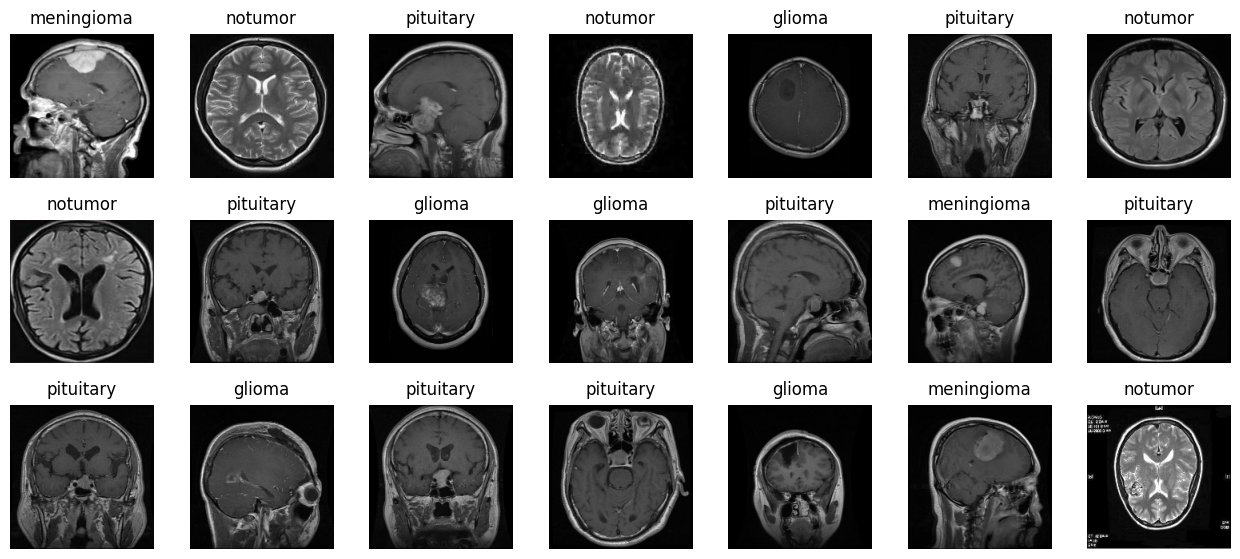

In [31]:
show_images(3, 7, training_data)

In [32]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.RandomRotation(10),          # Randomly rotate images up to 10 degrees
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize(                   # Normalize pixel values
        mean=[0.485, 0.456, 0.406],         # Mean values for each color channel
        std=[0.229, 0.224, 0.225]           # Standard deviation values for each color channel
    )
])

In [33]:
train_dataset = ImageFolder(train_df, transform = data_transforms)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

In [34]:
test_dataset = ImageFolder(test_df, transform = data_transforms)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [35]:
image_shape = (image_size[0], image_size[1], 3)

In [36]:
model = models.Sequential()


# input layer
model.add(Conv2D(32, (4, 4), activation="relu", input_shape = image_shape)) #using relu as the activation function
model.add(MaxPooling2D(pool_size=(3, 3)))

# hidden layers
model.add(Conv2D(64, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(Flatten()) #used to convert the output from the last convolutional layer into a one-dimensional array that can be passed to the fully connected layers

# output layer
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed = 111))
model.add(Dense(4, activation="softmax")) #4 -> number of classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 177, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0

In [37]:
model.compile(optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995), loss='categorical_crossentropy', metrics= ['accuracy'])

In [38]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_df,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=111)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_df,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=111)

Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [39]:
history = model.fit(train_generator,
                        steps_per_epoch = 100,
                        epochs = 40,
                        validation_data = test_generator,
                        validation_steps = 40)

Epoch 1/40
100/100 [==============================] - 988s 10s/step - loss: 0.9784 - accuracy: 0.5560 - val_loss: 0.7230 - val_accuracy: 0.7125
Epoch 2/40
100/100 [==============================] - 384s 4s/step - loss: 0.5861 - accuracy: 0.7621 - val_loss: 0.5990 - val_accuracy: 0.7602
Epoch 3/40
100/100 [==============================] - 281s 3s/step - loss: 0.5113 - accuracy: 0.8015 - val_loss: 0.6142 - val_accuracy: 0.7500
Epoch 4/40
100/100 [==============================] - 200s 2s/step - loss: 0.4204 - accuracy: 0.8328 - val_loss: 0.4784 - val_accuracy: 0.8031
Epoch 5/40
100/100 [==============================] - 218s 2s/step - loss: 0.4061 - accuracy: 0.8372 - val_loss: 0.4236 - val_accuracy: 0.8398
Epoch 6/40
100/100 [==============================] - 201s 2s/step - loss: 0.3100 - accuracy: 0.8845 - val_loss: 0.4007 - val_accuracy: 0.8422
Epoch 7/40
100/100 [==============================] - 202s 2s/step - loss: 0.3064 - accuracy: 0.8835 - val_loss: 0.3620 - val_accuracy: 0.852

KeyboardInterrupt: ignored

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 1 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 1 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [ ]:
model2 = models.Sequential()

# input layer
model2.add(Conv2D(32, (4, 4), activation="relu", input_shape = image_shape, padding='same'))
model2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

# hidden layers
model2.add(Conv2D(64, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model2.add(Conv2D(128, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model2.add(Conv2D(128, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model2.add(Conv2D(256, (4, 4), activation="relu", padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(Flatten())

# output layer
model2.add(Dense(512, activation="relu"))
model2.add(Dropout(0.5, seed = 111))
model2.add(Dense(4, activation="softmax"))

model2.summary()

In [ ]:
model2.compile(optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995), loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history2 = model2.fit(train_generator,
                        steps_per_epoch = 100,
                        epochs = 40,
                        validation_data = test_generator,
                        validation_steps = 40)